In [1]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, timedelta
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import itertools
PATH_TO_DATA = "D:/Temp/Programming/proj_data/taxi/"

C:\Program Files\Python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
nyc_long = [-74.25559, -73.70001]
nyc_lat = [40.49612, 40.91553]
ESTB = [-73.985428, 40.748817]
step_long = (nyc_long[1] - nyc_long[0]) / 50
step_lat = (nyc_lat[1] - nyc_lat[0]) / 50


In [3]:
df = pd.read_csv(PATH_TO_DATA + "yellow_tripdata_2016-05.csv", 
                 parse_dates = ['tpep_pickup_datetime',
                                'tpep_dropoff_datetime'])
shape0 = df.shape
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [4]:
df = df[(df.passenger_count > 0) &
        (df.trip_distance != 0) &
        ((df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.seconds > 0) &
        (df.pickup_longitude >= nyc_long[0]) &
        (df.pickup_longitude <= nyc_long[1]) &
        (df.pickup_latitude <= nyc_lat[1]) & 
        (df.pickup_latitude >= nyc_lat[0])]

In [5]:
print("Было ", shape0)
print("Стало ", df.shape)

Было  (11836853, 19)
Стало  (11626521, 19)


In [6]:
regions = pd.read_csv(PATH_TO_DATA + "regions.csv", index_col=0, sep=';')
regions.head()

,west,east,south,north
region,,,,
1,-74.25559,-74.244478,40.496120,40.504508
2,-74.25559,-74.244478,40.504508,40.512896
3,-74.25559,-74.244478,40.512896,40.521285
4,-74.25559,-74.244478,40.521285,40.529673
5,-74.25559,-74.244478,40.529673,40.538061


Попытка решить через binned_statistic_2d не удалась, номера регионов не совпадали с номерами из файла. Пришлось писать свою функцию.
'''
binx = np.unique(np.hstack((regions.west, regions.east)))
biny = np.unique(np.hstack((regions.south, regions.north)))
binx.shape, biny.shape
ret = binned_statistic_2d(df.pickup_longitude, 
                          df.pickup_latitude, 
                          df.iloc[:, 5:7].values, 
                          bins=[binx, biny], statistic='count')
'''

In [7]:
def add_regions(data):
    r = np.zeros(data.shape[0], dtype=int)
    for idx, (long, lat) in enumerate(zip(data.pickup_longitude, data.pickup_latitude)):
        r[idx] = reg_num(long, lat)
    data["reg_id"] = r
    return data


def reg_num(long, lat):
    diff_long = long - nyc_long[0]
    diff_lat = lat - nyc_lat[0]
    return int(diff_long//step_long * 50 + diff_lat//step_lat + 1)

In [8]:
df = add_regions(df)
df.tpep_pickup_datetime  = df.tpep_pickup_datetime.dt.floor('1H')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,reg_id
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,1233
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,1180
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,1180
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,1173
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,1130


In [9]:
aggr_data = df.groupby(['tpep_pickup_datetime','reg_id']).size().reset_index().rename(columns={0: 'num_trips'})
aggr_data.head()

,tpep_pickup_datetime,reg_id,num_trips
0,2016-05-01,1015,1
1,2016-05-01,1017,1
2,2016-05-01,1029,3
3,2016-05-01,1030,1
4,2016-05-01,1033,4


In [10]:
hours = pd.date_range(start='2016-05-01', end='2016-06-01', freq='1H', closed='left')
index_grid = pd.DataFrame(itertools.product(hours, range(1, 2501)), columns=['tpep_pickup_datetime', 'reg_id'])
aggr_data = index_grid.merge(aggr_data, on=['tpep_pickup_datetime', 'reg_id'], how='left').fillna({'num_trips': 0})
aggr_data['num_trips'] = aggr_data['num_trips'].astype(np.int64)
aggr_data.to_csv(PATH_TO_DATA + "yellow_tripdata_2016-05.aggr.csv")
aggr_data.head()

,tpep_pickup_datetime,reg_id,num_trips
0,2016-05-01,1,0
1,2016-05-01,2,0
2,2016-05-01,3,0
3,2016-05-01,4,0
4,2016-05-01,5,0


In [11]:
estb_data = aggr_data[aggr_data.reg_id == reg_num(ESTB[0], ESTB[1])].copy()
estb_data.head()

,tpep_pickup_datetime,reg_id,num_trips
1230,2016-05-01 00:00:00,1231,881
3730,2016-05-01 01:00:00,1231,713
6230,2016-05-01 02:00:00,1231,533
8730,2016-05-01 03:00:00,1231,418
11230,2016-05-01 04:00:00,1231,353


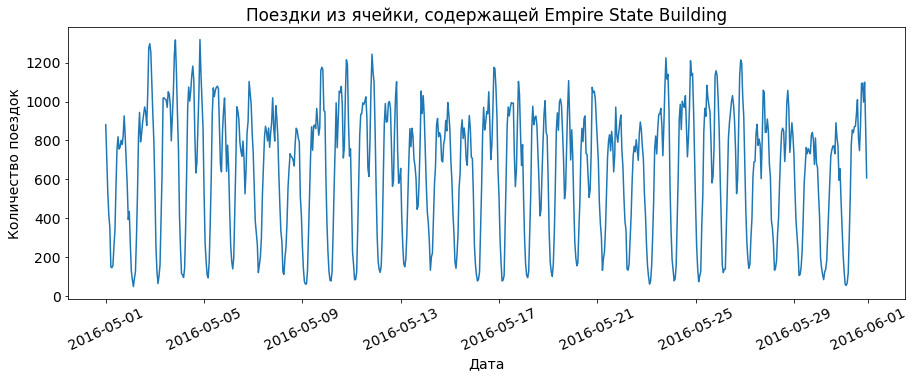

In [12]:
pd.plotting.register_matplotlib_converters()
plt.figure(1, figsize=(15, 5))
plt.rcParams.update({"font.size": 14})
plt.xticks(rotation=25)
plt.plot_date(estb_data.tpep_pickup_datetime, estb_data.num_trips, "-")
plt.title("Поездки из ячейки, содержащей Empire State Building")
plt.xlabel("Дата")
plt.ylabel("Количество поездок")
plt.show()

In [14]:
print("Количество строк с нулевым количеством поездок равно", np.sum(aggr_data.num_trips == 0))

Количество строк с нулевым количеством поездок равно 1718238
